## センチメント分析の実装

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


### データセット

#### Hugging Faceからサンプルデータの取得

Hugging Faceのには色々なデータセットが用意されております。ここでは、多言語のセンチメントデータセットを例として使用することにします。その中に、英語と日本語のサプセットが含まれます。

In [2]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: lvzeyu1995 (lvzeyu1995-tohoku-university). Use `wandb login --relogin` to force relogin


True

In [3]:
import os
os.environ["WANDB_PROJECT"]="sentiment_analysis_jp"

In [4]:
from datasets import load_dataset
dataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese")
#dataset = load_dataset("tyqiangz/multilingual-sentiments", "english")

#### サンプルデータの確認

取得したデータセットの中身を確認します。

データセットはこのようにtrain, validation, testに分かれています。
['text', 'source', 'label']といった情報を持っています。


In [5]:
dataset["train"] = dataset["train"].shuffle(seed=42).select(range(10000))

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
})

In [7]:
dataset.set_format(type="pandas")
train_df = dataset["train"][:]
train_df.head(5)

,text,source,label
0,4つ購入したが、2つは使用できず。接触が悪いのかわからないが、2度と購入しません,amazon_reviews_multi,2
1,キャンプでカセットコンロを使用しています。 キャンプでちょっと変わった事がしたくて購入！笑 ...,amazon_reviews_multi,0
2,こちらのiTunesカード200＄分を購入しました。 50＄４枚購入したはずが、届いたのは5...,amazon_reviews_multi,2
3,macbook pro 13インチと書いてあったので書いてあったので購入しましたが2016l...,amazon_reviews_multi,1
4,安かろう悪かろうです。 TVはが悪く暗く自動サーチなしでいちいちサーチしなおさなければダメ。...,amazon_reviews_multi,2


In [8]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'source': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'neutral', 'negative'], id=None)}

<Axes: title={'center': 'Train Dataset'}, ylabel='label'>

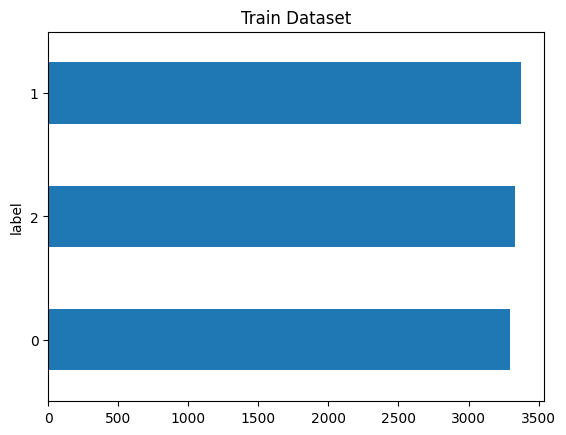

In [9]:
import matplotlib.pyplot as plt
train_df["label"].value_counts(ascending=True).plot(kind="barh", title="Train Dataset")

#### テキストの確認

Transformerモデルは、最大コンテキストサイズ(maximum context size)と呼ばれる最大入力系列長があります。

モデルのコンテキストサイズより長いテキストは切り捨てる必要があり、切り捨てたテキストに重要な情報が含まれている場合、性能の低下につながることがあります。

In [10]:
train_df["text_length"]=train_df["text"].str.len()

<Axes: title={'center': 'text_length'}, xlabel='label'>

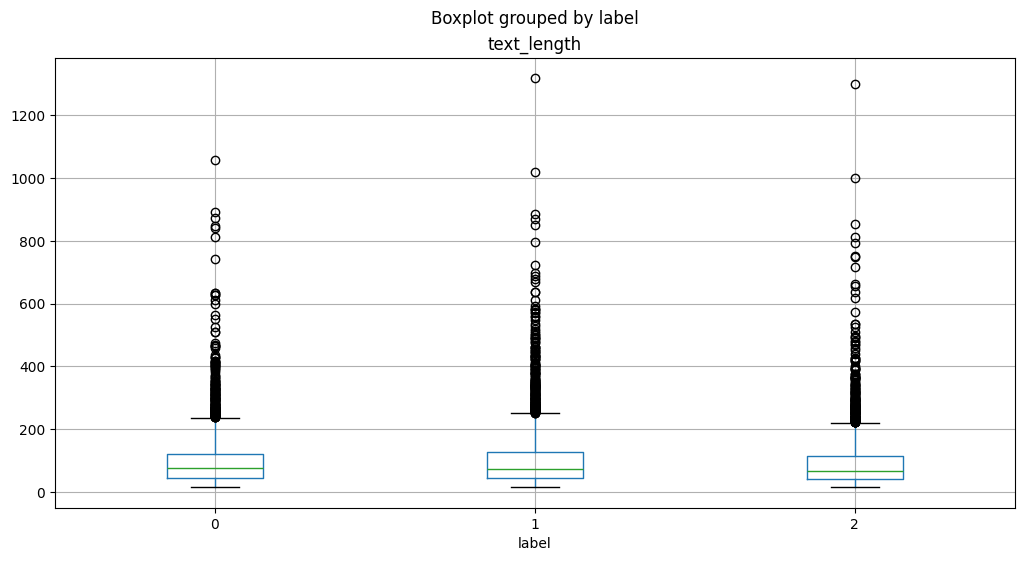

In [11]:
train_df.boxplot(column="text_length", by="label", figsize=(12, 6))


### トークン化

コンピュータは、入力として生の文字列を受け取ることができません。その代わりに、テキストがトークン化され、数値ベクトルとしてエンコードされていることが想定しています。

トークン化は、文字列をモデルで使用される最小単位に分解するステップです。

Transformerライブラリー は便利なAutoTokenizerクラスを提供しており、事前学習済みモデルに関連つけられたトークナイザーを素早く使用することができます。

#### トークナイザの動作確認


tokenizerテキストを数値形式（トークン）に変換します。
- 入力テキストをトークンに分割します
- 特殊トークンが自動的に付加されます
- トークンをトークンIDに変換します

In [12]:
from transformers import AutoTokenizer
model_ckpt = "tohoku-nlp/bert-base-japanese"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/Users/ryozawau/anaconda3/envs/jupyterbook/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/ryozawau/anaconda3/envs/jupyterbook/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
train_df["text"][0]

'4つ購入したが、2つは使用できず。接触が悪いのかわからないが、2度と購入しません'

In [14]:
sample_text_encoded = tokenizer(train_df["text"][0])
sample_text_encoded

{'input_ids': [2, 57, 181, 2630, 15, 10, 14, 6, 25, 181, 9, 406, 203, 255, 8, 5278, 14, 6981, 5, 29, 11183, 80, 14, 6, 25, 559, 13, 2630, 15, 6769, 1058, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

結果にinput_idsとattention_maskが含まれます。

- input_ids: 数字にエンコードされたトークン
- attention_mask: モデルで有効なトークンかどうかを判別するためのマスクです。無効なトークン（例えば、PADなど）に対しては、attention_maskを
として処理します。

各batchにおいて、入力系列はbatch内最大系列長までpaddingされます。

 ![](./Figure/attention_id.png)


トークナイザの結果は数字にエンコードされているため、トークン文字列を得るには、convert_ids_to_tokensを用います。

文の開始が[CLS]、文の終了が[SEP]という特殊なトークンとなっています。

In [15]:
tokens = tokenizer.convert_ids_to_tokens(sample_text_encoded.input_ids)
print(tokens)

['[CLS]', '4', 'つ', '購入', 'し', 'た', 'が', '、', '2', 'つ', 'は', '使用', 'でき', 'ず', '。', '接触', 'が', '悪い', 'の', 'か', 'わから', 'ない', 'が', '、', '2', '度', 'と', '購入', 'し', 'ませ', 'ん', '[SEP]']


#### データセット全体のトークン化



In [16]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [17]:
dataset.reset_format()

In [18]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Parameter 'function'=<function tokenize at 0x346102b60> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [19]:
import pandas as pd
sample_encoded = dataset_encoded["train"][0]
pd.DataFrame(
    [sample_encoded["input_ids"]
     , sample_encoded["attention_mask"]
     , tokenizer.convert_ids_to_tokens(sample_encoded["input_ids"])],
    ['input_ids', 'attention_mask', "tokens"]
).T

,input_ids,attention_mask,tokens
0,2,1,[CLS]
1,57,1,4
2,181,1,つ
3,2630,1,購入
4,15,1,し
...,...,...,...
507,0,0,[PAD]
508,0,0,[PAD]
509,0,0,[PAD]
510,0,0,[PAD]


### 分類器の実装
#### 事前学習モデルの導入

Transformerライブラリは事前学習モデルの使用ため```AutoModel```クラスを提供します。

```AutoModel```クラスはトークンエンコーディングを埋め込みに変換し、エンコーダスタックを経由して**最後の**隠れ状態を返します。


In [20]:
import torch
from transformers import AutoModel

# GPUある場合はGPUを使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

/Users/ryozawau/anaconda3/envs/jupyterbook/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/Users/ryozawau/anaconda3/envs/jupyterbook/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/ryozawau/anaconda3/envs/jupyterbook/lib/python3.12/site-packages/transformers/modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted 

最初に、文字列をエンコーダしてトークンをPyTorchのテンソルに変換する必要があります。

結果として得られるテンソルは```[batch_size,n_tokens]```という形状です。

In [21]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 8])


得られるテンソルをモデルの入力として渡します。

- モデルと同じデバイス(GPU or CPU)に設置します。
- 計算のメモリを減らせるため、```torch.no_grad()```で、勾配の自動計算を無効します。
- 出力には隠れ状態、損失、アテンションのオブジェクトが含まれます。

In [22]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 3.4831e-01, -3.4548e-01,  4.8135e-02,  ..., -2.1422e-01,
           3.4672e-01,  4.4654e-01],
         [ 3.6010e-01,  3.3539e-01, -8.0582e-01,  ...,  9.8438e-01,
          -1.5404e-01,  1.0238e-03],
         [ 4.4720e-01, -5.0319e-01, -7.8903e-01,  ...,  4.6996e-01,
          -1.4486e-01,  3.4748e-01],
         ...,
         [-1.8473e-01, -6.0161e-01,  3.5366e-01,  ...,  7.5156e-02,
          -5.3383e-01,  4.8803e-01],
         [ 5.2880e-01,  1.9102e-01, -3.0294e-01,  ..., -5.4689e-03,
          -1.3497e-01,  7.4433e-01],
         [-1.6111e-01,  2.1320e-01, -5.7311e-01,  ...,  5.9892e-01,
          -2.0213e-01,  1.2702e+00]]]), pooler_output=tensor([[ 2.2298e-01,  7.6244e-01,  4.4263e-01,  5.0896e-02,  3.1429e-01,
         -2.8330e-01,  1.2347e-01,  2.5323e-01,  3.4149e-02, -1.4088e-01,
          4.2941e-01,  1.0587e-01,  7.9725e-01, -4.1017e-01,  1.9951e-01,
         -3.3257e-01,  6.6790e-01, -7.1064e-03, -3.928

隠れた状態テンソルを見ると、その形状は [batch_size, n_tokens, hidden_dim] であることがわかります。つまり、6つの入力トークンのそれぞれに対して、768次元のベクトルが返されます。

In [23]:
outputs.last_hidden_state.size()

torch.Size([1, 8, 768])

分類タスクでは、```[CLS]``` トークンに関連する隠れた状態を入力特徴として使用するのが一般的な方法です。このトークンは各シーケンスの始まりに現れるため、次のように outputs.last_hidden_state に単純にインデックスを付けることで抽出できます。

In [24]:
outputs.last_hidden_state[:,0].size()


torch.Size([1, 768])

最後の隠れ状態を取得する方法がわかりましたので、データ全体に対して処理を行うため、これまでのステップを関数でまとめます。

そして、データ全体に適用し、すべてのテキストの隠れ状態を抽出します。

In [25]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [26]:
dataset_encoded.set_format(type="torch", columns=["input_ids", "attention_mask","label"])


In [27]:
dataset_hidden=dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

KeyboardInterrupt: 

#### 分類器の学習

前処理されたデータセットには、分類器を学習させるために必要な情報がすべて含まれています。

具体的には、隠れ状態を入力特徴量として、ラベルをターゲットとして使用すると、様々な分類アルゴリズムに適用できるだろう。

ここで、ロジスティック回帰モデルを学習します。

In [48]:
import numpy as np

X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((1839, 768), (324, 768))

In [49]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [50]:
lr_clf.score(X_valid, y_valid)

0.5987654320987654

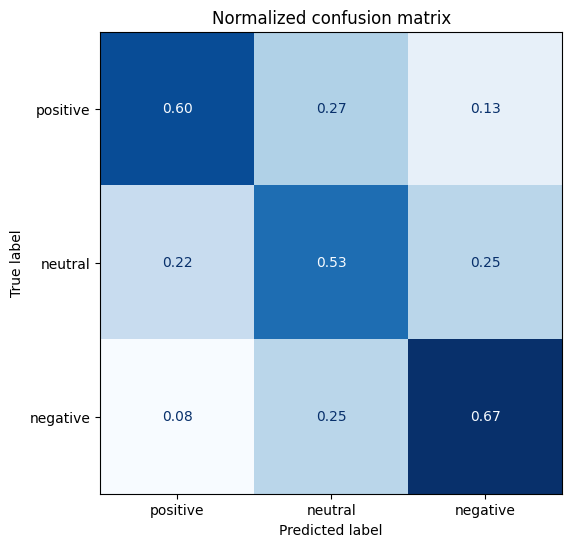

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, ["positive","neutral","negative"])

#### AutoModelForSequenceClassificationのファインチューニング


transformerライブラリは、ファインチューニングのタスクに応じてAPIを提供しています。

分類タスクの場合、```AutoModel```の代わりに```AutoModelForSequenceClassification```を使用します。

```AutoModelForSequenceClassification```が事前学習済みモデルの出力の上に分類器ヘッドを持っており、モデルの設定がより簡単になります。

In [52]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 3

model = (AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [1]:
inputs = tokenizer("I purchased these boots to use both for everyday wear and when riding my motorcycle.", return_tensors="pt") # pytorch tensorに変換するためにreturn_tensors="pt"を指定
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

NameError: name 'tokenizer' is not defined

#### 学習の準備

学習時に性能指標を与える必要があるため、それを関数化して定義しておきます。




In [55]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

学習を効率化するために、transformerライブラリの```Trainer``` APIを使用します。

```Trainer```クラスを初期化する際には、```TrainingArguments```という訓練に関する様々な設定値の集合を引数に与えることで、訓練の設定に関する細かい調整が可能です。

In [56]:

from transformers import TrainingArguments

batch_size = 16
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = "sample-text-classification-bert"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

Trainerクラスで実行します。

結果を確認すると、特徴ベースのアプローチよりも精度が改善されることがわかります。

In [57]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.001000,0.822080,0.623457,0.598058
2,0.746200,0.730626,0.672840,0.660265


TrainOutput(global_step=230, training_loss=0.8717699584753617, metrics={'train_runtime': 7.9795, 'train_samples_per_second': 460.93, 'train_steps_per_second': 28.824, 'total_flos': 74225497893768.0, 'train_loss': 0.8717699584753617, 'epoch': 2.0})

### 学習済みモデルの使用

#### モデル精度の検証

学習済みのモデルを他のデータセットに適用します。



In [58]:
preds_output = trainer.predict(dataset_encoded["test"])

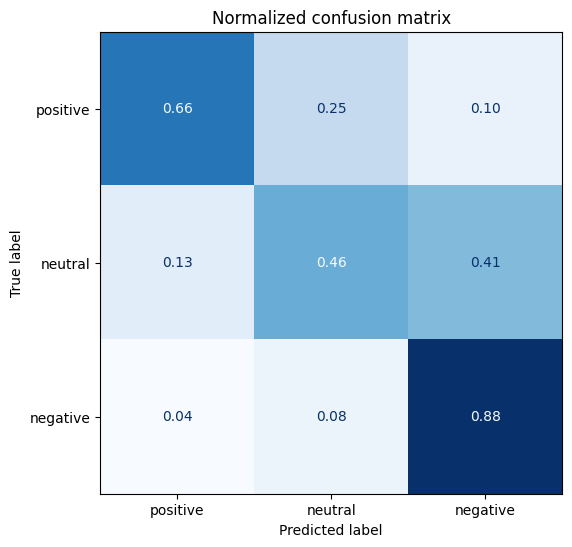

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(dataset_encoded["test"]["label"])
labels = dataset_encoded["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

#### モデル保存



In [61]:
id2label = {}
for i in range(dataset["train"].features["label"].num_classes):
    id2label[i] = dataset["train"].features["label"].int2str(i)

label2id = {}
for i in range(dataset["train"].features["label"].num_classes):
    label2id[dataset["train"].features["label"].int2str(i)] = i

trainer.model.config.id2label = id2label
trainer.model.config.label2id = label2id

In [62]:
trainer.save_model(f"./Data/sample-text-classification-bert")

#### 学習済みモデルの読み込み


In [63]:
new_tokenizer = AutoTokenizer\
    .from_pretrained(f"./Data/sample-text-classification-bert")

new_model = (AutoModelForSequenceClassification
    .from_pretrained(f"./Data/sample-text-classification-bert")
    .to(device))

サンプルテキストで推論の結果を確認します。



In [64]:
def id2label(x):
    label_dict={0:"positive",1:"neutral",2:"negative"}
    return label_dict[x]

In [65]:
text1="this week is not going as i had hoped"
text2="awe i love you too!!!! 1 am here i miss you"

In [66]:

inputs = new_tokenizer(text1, return_tensors="pt")

new_model.eval()

with torch.no_grad():
    outputs = new_model(
        inputs["input_ids"].to(device), 
        inputs["attention_mask"].to(device),
    )
outputs.logits

y_preds = np.argmax(outputs.logits.to('cpu').detach().numpy().copy(), axis=1)
y_preds = [id2label(x) for x in y_preds]
y_preds

['negative']

In [67]:
inputs = new_tokenizer(text2, return_tensors="pt")

new_model.eval()

with torch.no_grad():
    outputs = new_model(
        inputs["input_ids"].to(device), 
        inputs["attention_mask"].to(device),
    )
outputs.logits

y_preds = np.argmax(outputs.logits.to('cpu').detach().numpy().copy(), axis=1)
y_preds = [id2label(x) for x in y_preds]
y_preds

['positive']